<a href="https://colab.research.google.com/github/Alberto-San/ExperimentosMonografia/blob/main/Clasificaci%C3%B3n_%26_Finne_Tunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Modelo de clasificación de cáncer cervical en muestras de tejido celular utilizando técnicas de aprendizaje automático:** Monografía presentada​ para optar al título de ​Especialista en Analítica y Ciencia de Datos​

**Estudiantes:**

Daniel Alberto López Sánchez, Ing Electronico. e-mail: daniel.lopez6@udea.edu.co

July Andrea Muñoz Lopera, Ing Industrial. e-mail: july.munoz@udea.edu.co
<br>
<br>

**Asesora:**
<br>
Maria Bernarda Salazar Sánchez, PhD. e-mail: bernarda.salazar@udea.edu.co

<br>

Universidad de Antioquia
<br>
​Facultad de Ingeniería​
<br>
​​Especialización en Analítica y Ciencia de Datos​
<br>
​​Medellín, Antioquia, Colombia​
<br>
2023

# Objetivo
Este notebook tiene como objetivo entrenar un clasificador de Máquina de Soporte Vectorial (SVM) para clasificar las características del espacio ICA obtenidas en el notebook **Preprocesamiento.ipynb**

# Descarga de Característica Documento CSV
Se descarga el repositorio MonografiaDataScience, el cual contiene el dataset de caracteristicas en la ruta ```MonografiaDataScience/tmp/filtered_data.csv```. Se divide los datos en terminos de train/test usando el proceso reportado en el notebook **Preprocesamiento.ipynb**, en el cual se usa la ```random_state=0```

In [1]:
!git clone https://github.com/Alberto-San/MonografiaDataScience

Cloning into 'MonografiaDataScience'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 179 (delta 69), reused 141 (delta 41), pack-reused 0
Receiving objects: 100% (179/179), 22.52 MiB | 2.91 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [4]:
from sklearn.model_selection import train_test_split
import pandas as pd

path = "MonografiaDataScience/tmp/filtered_data.csv"
original_dataset = pd.read_csv(path)

# Eliminando la columna image_path
dataset = original_dataset.drop("image_path", axis=1)

# Obteniendo los descriptores y las etiquetas
features, vector_label = dataset.drop("class", axis=1), dataset["class"] 

# Convirtiendo las etiquetas de string a numeros
vector_numeric_label_dic = pd.factorize(vector_label)
vector_numeric_label = vector_numeric_label_dic[0]
vector_numeric_label_index = vector_numeric_label_dic[1]

# Split data en train y test
features_train, features_test, vector_label_train, vector_label_test = train_test_split(
      features, vector_numeric_label, 
      test_size=0.2, 
      random_state=0, 
      stratify=vector_numeric_label
    )

# Descarga de Modelo de Reducción de Dimensionalidad
Del notebook **Preprocesamiento.ipynb**, se dedujo que el método de reducción de dimensionalidad que representa mejor los datos y maximiza su separación es el de Análisis de Componentes Independientes (ICA). Se guardó este modelo en la ruta ```MonografiaDataScience/tmp/ica_model.joblib ```

In [8]:
from joblib import load

path_ica_model = "MonografiaDataScience/tmp/ica_model.joblib"

# Cargar modelo
ica_model = load(path_ica_model)

# Transformacion data train y test a espacio ICA
features_train_ica, features_test_ica = ica_model.transform(features_train), ica_model.transform(features_test)

# Máquina de Soporte Vectorial (SVM)
Son un tipo de algoritmo de aprendizaje automático supervisado utilizado para la clasificación y la regresión. La idea detrás de las SVM es encontrar un hiperplano que separe óptimamente las diferentes clases de datos. En el caso de la clasificación, se busca un hiperplano que separe las diferentes clases de datos de manera que maximice la distancia (margen) entre las clases más cercanas al hiperplano. Los datos que se encuentran más cercanos al hiperplano se denominan vectores de soporte, de ahí el nombre de la técnica. Las máquinas de Soporte Vectorial en particular, son capaces de manejar datos de alta dimensionalidad y pueden generalizar bien a datos no vistos previamente. También son robustas a la presencia de datos atípicos y son relativamente sencillas de ajustar.

# Configuración del Experimento
Se usa el módulo ```SVC```de la librería sklearn. Para encontrar el mejor clasificador, se hace uso de una grilla de hiperparámetros, donde se evalúa el ``` accuracy ```, y se escoge el mejor clasificador que maximiza esta métrica

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# Definiendo los hiperparametros
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
              'kernel': ['rbf', 'sigmoid', 'linear', 'poly'],
              'degree': [2, 3, 4],
              'coef0': [-1, 0, 1]}

# Set up a dictionary to store the results
results = []

# Loop sobre todas las combinaciones de los hiperparametros
for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:
            for degree in param_grid['degree']:
                for coef0 in param_grid['coef0']:
                    
                    # Crear SVM con parametros
                    svm = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree, coef0=coef0)
                    
                    # Entrenar Modelo
                    svm.fit(features_train_ica, vector_label_train)
                    
                    # Prediccion sobre data de test
                    y_pred = svm.predict(features_test_ica)

                    # Calculo Accuracy
                    accuracy = accuracy_score(vector_label_test, y_pred)

                    # Calculo de la matriz de confusion
                    conf_mat = confusion_matrix(vector_label_test, y_pred)
                    
                    # Añadir Resultados
                    results.append([C, gamma, kernel, degree, coef0, accuracy, conf_mat])

In [13]:
summary_performance = pd.DataFrame(results, columns=["C", "gamma", "kernel", "degree", "coef0", "accuracy", "conf_mat"])
summary_performance.sort_values(by=["accuracy"], ascending=False)

,C,gamma,kernel,degree,coef0,accuracy,conf_mat
1085,100.0,scale,rbf,3,1,0.946684,"[[157, 0, 0, 0, 1], [0, 147, 0, 1, 6], [0, 1, ..."
1082,100.0,scale,rbf,2,1,0.946684,"[[157, 0, 0, 0, 1], [0, 147, 0, 1, 6], [0, 1, ..."
1080,100.0,scale,rbf,2,-1,0.946684,"[[157, 0, 0, 0, 1], [0, 147, 0, 1, 6], [0, 1, ..."
1088,100.0,scale,rbf,4,1,0.946684,"[[157, 0, 0, 0, 1], [0, 147, 0, 1, 6], [0, 1, ..."
1087,100.0,scale,rbf,4,0,0.946684,"[[157, 0, 0, 0, 1], [0, 147, 0, 1, 6], [0, 1, ..."
...,...,...,...,...,...,...,...
1257,100.0,0.1,poly,4,-1,0.001300,"[[0, 124, 4, 6, 24], [106, 0, 35, 11, 2], [89,..."
1251,100.0,0.1,poly,2,-1,0.001300,"[[0, 123, 4, 6, 25], [111, 0, 30, 11, 2], [90,..."
1143,100.0,auto,poly,2,-1,0.001300,"[[0, 124, 3, 4, 27], [123, 0, 22, 9, 0], [95, ..."
1293,100.0,1,poly,4,-1,0.001300,"[[0, 123, 6, 7, 22], [102, 0, 36, 13, 3], [87,..."


De la tabla anterior, podemos ver que el mejor kernel es rbf, con gamma como scale y C como 100. Degree y coef0 no son parámetros importantes porque solo afectan a los kernels poly y sigmoid. Dado que C=100 es un valor extremo, podría valer la pena explorar otros valores haciendo un experimento adicional.

In [18]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# Definiendo los hiperparametros
param_grid = {'C': [10 + index for index in range(1, 100)],
              'gamma': ['scale'],
              'kernel': ['rbf'],
            }

# Set up a dictionary to store the results
results_refined = []

# Loop sobre todas las combinaciones de los hiperparametros
for C in param_grid['C']:
    for gamma in param_grid['gamma']:
        for kernel in param_grid['kernel']:

          # Crear SVM con parametros
          svm = SVC(C=C, gamma=gamma, kernel=kernel)
          
          # Entrenar Modelo
          svm.fit(features_train_ica, vector_label_train)
          
          # Prediccion sobre data de test
          y_pred = svm.predict(features_test_ica)

          # Calculo Accuracy
          accuracy = accuracy_score(vector_label_test, y_pred)

          # Calculo de la matriz de confusion
          conf_mat = confusion_matrix(vector_label_test, y_pred)
          
          # Añadir Resultados
          results_refined.append([C, gamma, kernel, accuracy, conf_mat])

pd.DataFrame(results_refined, columns=["C", "gamma", "kernel", "accuracy", "conf_mat"]).sort_values(by=["accuracy"], ascending=False)


,C,gamma,kernel,accuracy,conf_mat
2,13,scale,rbf,0.949285,"[[158, 0, 0, 0, 0], [0, 143, 1, 1, 9], [0, 1, ..."
3,14,scale,rbf,0.949285,"[[158, 0, 0, 0, 0], [0, 144, 0, 1, 9], [0, 1, ..."
5,16,scale,rbf,0.949285,"[[158, 0, 0, 0, 0], [0, 145, 0, 1, 8], [0, 1, ..."
21,32,scale,rbf,0.947984,"[[158, 0, 0, 0, 0], [0, 145, 0, 1, 8], [0, 1, ..."
14,25,scale,rbf,0.947984,"[[158, 0, 0, 0, 0], [0, 145, 0, 1, 8], [0, 1, ..."
...,...,...,...,...,...
48,59,scale,rbf,0.945384,"[[157, 0, 0, 0, 1], [0, 146, 0, 1, 7], [0, 1, ..."
50,61,scale,rbf,0.945384,"[[157, 0, 0, 0, 1], [0, 146, 0, 1, 7], [0, 1, ..."
51,62,scale,rbf,0.945384,"[[157, 0, 0, 0, 1], [0, 146, 0, 1, 7], [0, 1, ..."
52,63,scale,rbf,0.945384,"[[157, 0, 0, 0, 1], [0, 146, 0, 1, 7], [0, 1, ..."


Se observa que cambiar el valor de C contribuye significativamente a una mejora del modelo. Esto puede explicarse dado que C es un parametro de regularizacion. Un valor mayor de C crea un margen más estrecho, lo que puede resultar en un sobreajuste a los datos de entrenamiento, pero también puede conducir a un mejor rendimiento de generalización en nuevos datos.

 # Analisis de Resultados
 Se observa que el accuracy obtenido es de 94,92%. Sin embargo, es de interés explorar como son aquellas clasificaciones de cada una de las clases individuales, para lo cual se explora la matriz de confusión

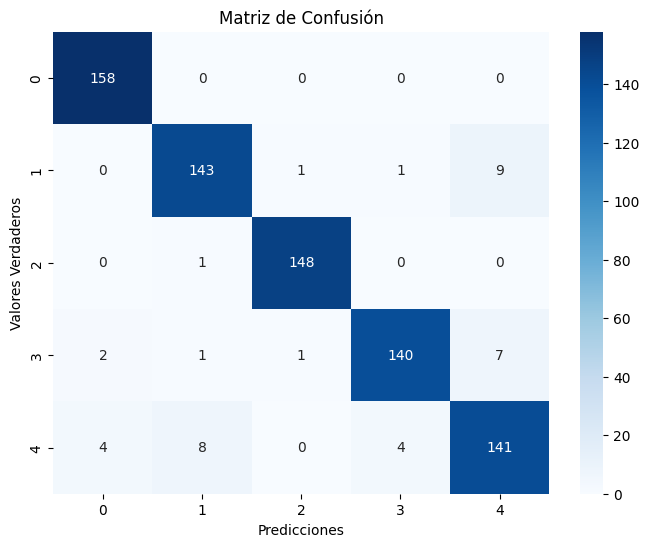

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns


# metricas generales
data = pd.DataFrame(results_refined, columns=["C", "gamma", "kernel", "accuracy", "conf_mat"]).sort_values(by=["accuracy"], ascending=False)

# matriz de confusion
cm = data["conf_mat"].iloc[0]

# Graficar la matriz de confusión usando la biblioteca seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Verdaderos')
plt.show()

Se observan en general buenas métricas en cada uno de los valores reportados en las clases.

# Comparación de resultados
Para la extracción de características, nos basamos en el artículo **Sipakmed: A New Dataset for Feature and Image Based Classification of Normal and Pathological Cervical Cells in Pap Smear Images**. En este artículo, se reportó un accuracy del 91,68% utilizando características celulares. Sin embargo, con nuestro enfoque, obtuvimos un 94,92% utilizando una SVM con kernel rbf, gamma scale y C=100. Observamos una mejor al utilizar ICA como espacio de características.

Se materializa el modelo SVM y se guarda de manera **manual** en el repositorio MonografiaDataScience, debido a que colab no puede hacer push directo a github

In [19]:
from joblib import dump

svm = SVC(C=13, gamma="scale", kernel="rbf")
svm.fit(features_train_ica, vector_label_train)

# Guardando modelo
dump(svm, 'svm_model.joblib')

['svm_model.joblib']